In [42]:
import whisperx
import torchaudio
device = "cuda" 
batch_size = 16 # reduce if low on GPU mem
compute_type = "int8" # change to "int8" if low on GPU mem (may reduce accuracy)

In [43]:
MP3_PATH = 'Schönleber_1.mp3'
MODEL_PATH = "i4ds/whisper4sg-srg-v2-full-mc-de-sg-corpus-v2"

In [44]:
vad_options = {'vad_onset': 0.5, 'vad_offset': 0.3}
#asr_options = {'temperatures': 0}

In [45]:
# 1. Transcribe with original whisper (batched)
model = whisperx.load_model(MODEL_PATH, device, compute_type=compute_type, language='de')#,  vad_options=vad_options) #asr_options=asr_options)

2024-05-07 14:54:59,760 - urllib3.connectionpool - DEBUG - https://huggingface.co:443 "GET /api/models/i4ds/whisper4sg-srg-v2-full-mc-de-sg-corpus-v2/revision/main HTTP/1.1" 200 709
2024-05-07 14:55:21,704 - fsspec.local - DEBUG - open file: /home/kenfus/.cache/torch/whisperx-vad-segmentation.bin
2024-05-07 14:55:21,782 - fsspec.local - DEBUG - open file: /home/kenfus/.cache/torch/whisperx-vad-segmentation.bin
Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.2.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.2+cu121. Bad things might happen unless you revert torch to 1.x.


In [46]:
import logging
# Configure logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a file handler that logs even debug messages
file_handler = logging.FileHandler('application.log')
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))

# Add the file handler to the logger
model.model.logger.addHandler(file_handler)

In [47]:
audio = torchaudio.load(MP3_PATH)

In [48]:
vad = model.vad_model({"waveform": audio[0], "sample_rate": audio[1]})

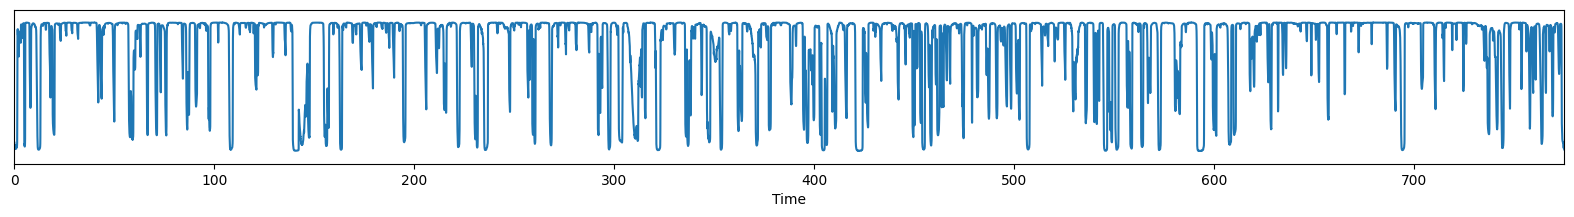

In [49]:
vad

In [50]:
audio = whisperx.load_audio(MP3_PATH)
result = model.transcribe(audio, batch_size=batch_size, language="de", print_progress=True, combined_progress=True)
print(result["segments"]) # before alignment

Progress: 1.61%...
Progress: 3.23%...
Progress: 4.84%...
Progress: 6.45%...
Progress: 8.06%...
Progress: 9.68%...
Progress: 11.29%...
Progress: 12.90%...
Progress: 14.52%...
Progress: 16.13%...
Progress: 17.74%...
Progress: 19.35%...
Progress: 20.97%...
Progress: 22.58%...
Progress: 24.19%...
Progress: 25.81%...
Progress: 27.42%...
Progress: 29.03%...
Progress: 30.65%...
Progress: 32.26%...
Progress: 33.87%...
Progress: 35.48%...
Progress: 37.10%...
Progress: 38.71%...
Progress: 40.32%...
Progress: 41.94%...
Progress: 43.55%...
Progress: 45.16%...
Progress: 46.77%...
Progress: 48.39%...
Progress: 50.00%...
[{'text': ' Wir hören die Lehre auf Medizin und Apparat. Frau Schönleber, habe ich gesehen, ruft Sie an. Können Sie mir kurz erzählen, wieso Sie heute bei mir anrufen? Genau, ich rufe an, weil ich nicht mehr zum Arzt komme. Und zwar ...', 'start': 1.459, 'end': 19.155}, {'text': ' Deshalb habe ich das Problem vom Rahmen geschoben. Seit acht Wochen habe ich so einen Husten, der geht u

In [51]:
# 2. Align whisper output
model_a, metadata = whisperx.load_align_model(language_code=result["language"], device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

print(result["segments"]) # after alignment


[{'start': 1.459, 'end': 4.422, 'text': ' Wir hören die Lehre auf Medizin und Apparat.', 'words': [{'word': 'Wir', 'start': 1.459, 'end': 1.599, 'score': 0.251}, {'word': 'hören', 'start': 1.659, 'end': 2.32, 'score': 0.67}, {'word': 'die', 'start': 2.36, 'end': 2.5, 'score': 0.47}, {'word': 'Lehre', 'start': 2.52, 'end': 2.84, 'score': 0.477}, {'word': 'auf', 'start': 2.86, 'end': 3.06, 'score': 0.415}, {'word': 'Medizin', 'start': 3.1, 'end': 3.521, 'score': 0.778}, {'word': 'und', 'start': 3.561, 'end': 3.701, 'score': 0.48}, {'word': 'Apparat.', 'start': 3.741, 'end': 4.422, 'score': 0.622}]}, {'start': 5.503, 'end': 8.345, 'text': 'Frau Schönleber, habe ich gesehen, ruft Sie an.', 'words': [{'word': 'Frau', 'start': 5.503, 'end': 5.883, 'score': 0.824}, {'word': 'Schönleber,', 'start': 5.923, 'end': 6.644, 'score': 0.781}, {'word': 'habe', 'start': 6.664, 'end': 6.784, 'score': 0.673}, {'word': 'ich', 'start': 6.824, 'end': 6.884, 'score': 0.901}, {'word': 'gesehen,', 'start': 6.9

In [52]:
import pysubs2

subs = pysubs2.load_from_whisper(result["segments"])
SRT_PATH = MODEL_PATH.split('/')[1] + '_' + compute_type + '_' + MP3_PATH.replace('.mp3','.srt')
subs.save(SRT_PATH)